In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from utils.utils import set_seed
set_seed()


from datetime import datetime, timedelta
from torch_geometric.nn import GATv2Conv, GATConv
from torch_geometric.utils import dense_to_sparse
from torch.distributions import Normal, Laplace, RelaxedOneHotCategorical
from torchdiffeq import odeint  # For continuous-time normalizing flows

from feature.scalers import ranged_scaler
from feature.engineering import *
from CARAT.model_utils import *
from CARAT.model import CausalGraphVAE
from CARAT.components import *
from utils.utils import set_seed, logger

# Torch settings
#torch.use_deterministic_algorithms(False)
#torch.backends.cudnn.benchmark = False
#torch.autograd.profiler.profile(enabled=False)
#torch.autograd.profiler.emit_nvtx(enabled=False)
#torch.autograd.set_detect_anomaly(mode=False)

# Environment variables
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = "1"

# Set device
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# Suppress warnings
warnings.filterwarnings('ignore')

# Load data
data = []
with open('data/TEP/idv1/y.dat', 'r') as file:
    for line in file:
        columns = line.strip().split("\t")
        data.append([float(col.strip()) for col in columns])


In [2]:
vars = len(data[0])
col_names = []
for i in  range(0,vars):
    col_names.append('x_'+str(i+1))
    

In [3]:
import polars as pl
from feature.scalers import ranged_scaler
df = pl.DataFrame(data,schema=col_names)
for col in df.columns:
    df = df.with_columns(ranged_scaler(df[col]))

In [4]:
df = make_stationary(df)

Column: x_1 | Final ADF: -5.4811 | p-value: 0.0000 | Diffs: 1
Column: x_2 | Final ADF: -3.6982 | p-value: 0.0003 | Diffs: 0
Column: x_3 | Final ADF: -3.6538 | p-value: 0.0003 | Diffs: 0
Column: x_4 | Final ADF: -3.3276 | p-value: 0.0010 | Diffs: 0
Column: x_5 | Final ADF: -28.9652 | p-value: 0.0000 | Diffs: 1
Column: x_6 | Final ADF: -27.3830 | p-value: 0.0000 | Diffs: 1
Column: x_7 | Final ADF: -5.1194 | p-value: 0.0000 | Diffs: 1
Column: x_8 | Final ADF: -30.8786 | p-value: 0.0000 | Diffs: 1
Column: x_9 | Final ADF: -3.0565 | p-value: 0.0024 | Diffs: 0
Column: x_10 | Final ADF: -5.8785 | p-value: 0.0000 | Diffs: 1
Column: x_11 | Final ADF: -5.5060 | p-value: 0.0000 | Diffs: 1
Column: x_12 | Final ADF: -27.0496 | p-value: 0.0000 | Diffs: 1
Column: x_13 | Final ADF: -5.5245 | p-value: 0.0000 | Diffs: 1
Column: x_14 | Final ADF: -29.4428 | p-value: 0.0000 | Diffs: 1
Column: x_15 | Final ADF: -23.7157 | p-value: 0.0000 | Diffs: 1
Column: x_16 | Final ADF: -5.1058 | p-value: 0.0000 | Diff

In [5]:
df=df.to_pandas()

In [6]:
#random dates, trivial for this exercise

start_date = '2023-03-01'  # Define the start date
date_range = pd.date_range(start=start_date, periods=df.shape[0])

In [7]:
n_lags = most_frequent(find_optimal_lags_for_dataframe(df))+1

In [8]:
df['time']=date_range

<Axes: xlabel='None', ylabel='x_44'>

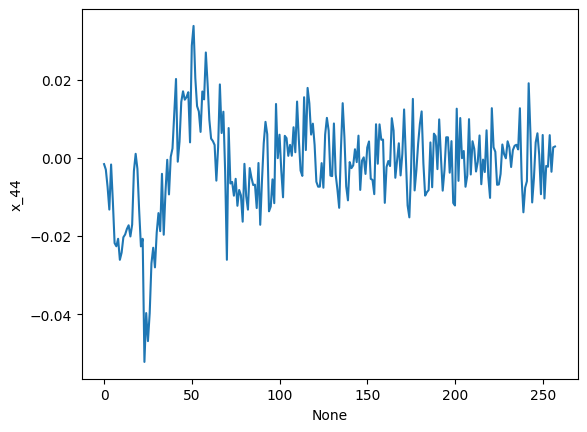

In [9]:
sns.lineplot(data=df,y='x_44',x=df.index)

In [10]:
df = df[['x_1', 'x_4','x_7','x_13','x_16','x_18','x_19','x_44','x_50']]

In [11]:
normal = df[200:]
bad = df[0:200]

In [12]:
df.columns

Index(['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_18', 'x_19', 'x_44', 'x_50'], dtype='object')

In [13]:
try:
    df = df.drop('time',axis=1)
except:
    None

try:
    normal = normal.drop('time',axis=1)
except:
    None
try:
    bad = bad.drop('time',axis=1)
except:
    None

In [14]:
cols = df.columns.tolist()

In [15]:
cols

['x_1', 'x_4', 'x_7', 'x_13', 'x_16', 'x_18', 'x_19', 'x_44', 'x_50']

# Pretraining

In [16]:
import torch
import random
import numpy as np

# Define the seed value
seed = 42

# Set seed for PyTorch
torch.manual_seed(seed)

# Set seed for CUDA (if using GPUs)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# Set seed for Python's random module
random.seed(seed)

# Set seed for NumPy
np.random.seed(seed)

# Ensure deterministic behavior for PyTorch operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [17]:
TIME_STEPS = 5
BATCH_SIZE = 25
hidden_dim = 64
latent_dim = 8
dataset_nominal = TimeSeriesDataset(normal, device=device, time_steps=TIME_STEPS)
dataloader_nominal = DataLoader(dataset_nominal, batch_size=BATCH_SIZE, shuffle=True)

# Initialize model and optimizer
model = CausalGraphVAE(input_dim=normal.shape[1], hidden_dim=hidden_dim,
                        latent_dim=latent_dim, num_nodes=normal.shape[1],device=device,
                        time_steps=TIME_STEPS, prior_adj=None,instantaneous_weight=0.3).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3, amsgrad =True)

# Train on nominal data
#print("Pretraining on nominal data...")
model.train_model(dataloader_nominal, optimizer, num_epochs=1000, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=2,alpha_max=2)

# Extract learned adjacency
prior_adj = model.causal_graph.adj_mat.clone().detach()
pd.DataFrame((prior_adj).cpu().detach().numpy(),index=cols,columns=cols)

Epoch 1: Loss = 231.3500
Recon Loss = 341.0206, KL Loss = 0.2543, Lagrangian Loss = 2.6673
Epoch 51: Loss = 38.6689
Recon Loss = 56.0460, KL Loss = 0.7276, Lagrangian Loss = 1.8577
Epoch 101: Loss = 26.1406
Recon Loss = 34.7812, KL Loss = 0.9826, Lagrangian Loss = 1.7645
Epoch 151: Loss = 19.7746
Recon Loss = 25.4570, KL Loss = 1.1139, Lagrangian Loss = 2.0742
Epoch 201: Loss = 15.9066
Recon Loss = 19.8245, KL Loss = 1.1680, Lagrangian Loss = 2.0851
Epoch 251: Loss = 12.9848
Recon Loss = 16.4142, KL Loss = 1.1717, Lagrangian Loss = 1.6846
Epoch 301: Loss = 11.5844
Recon Loss = 14.6023, KL Loss = 1.1239, Lagrangian Loss = 1.7509
Epoch 351: Loss = 10.3417
Recon Loss = 12.0815, KL Loss = 1.0827, Lagrangian Loss = 2.6398
Epoch 401: Loss = 9.5122
Recon Loss = 11.0253, KL Loss = 1.0202, Lagrangian Loss = 2.0862
Epoch 451: Loss = 8.2993
Recon Loss = 9.4997, KL Loss = 0.9272, Lagrangian Loss = 1.9133
Epoch 501: Loss = 7.7661
Recon Loss = 8.0485, KL Loss = 0.9419, Lagrangian Loss = 2.4095
Epoch

,x_1,x_4,x_7,x_13,x_16,x_18,x_19,x_44,x_50
x_1,0.000000,0.601530,0.546305,0.595542,0.555469,0.564844,0.577276,0.596922,0.585735
x_4,0.576992,0.000000,0.566479,0.591449,0.565654,0.577996,0.587286,0.561955,0.565267
x_7,0.588629,0.582904,0.000000,0.590842,0.593104,0.576998,0.591593,0.562137,0.593356
x_13,0.578270,0.556717,0.581635,0.000000,0.548276,0.588425,0.575095,0.588976,0.592500
x_16,0.570990,0.581675,0.599689,0.584679,0.000000,0.570158,0.598075,0.597638,0.573802
x_18,0.593639,0.573121,0.565424,0.578415,0.592880,0.000000,0.606357,0.577913,0.565785
x_19,0.570038,0.564308,0.565326,0.577313,0.588701,0.569644,0.000000,0.579350,0.592874
x_44,0.611028,0.591174,0.576100,0.576284,0.569356,0.580335,0.571339,0.000000,0.579962
x_50,0.580839,0.570932,0.597627,0.570488,0.578604,0.584646,0.572250,0.582709,0.000000


In [23]:
TIME_STEPS = 5
BATCH_SIZE = 25
hidden_dim = 64
latent_dim = 8
edge_correct = 0
instantaneous_correct = 0
lagged_correct = 0
counterfactual_correct = 0 
rr_correct = 0
total_correct = 0
total_checked = 0
for i in range(30):
    total_checked+=1

    dataset_bad = TimeSeriesDataset(bad, device=device, time_steps=TIME_STEPS)
    dataloader_bad = DataLoader(dataset_bad, batch_size=BATCH_SIZE, shuffle=True)
    
    # Initialize model and optimizer
    fine_tuned = CausalGraphVAE(input_dim=bad.shape[1], hidden_dim=hidden_dim,
                            latent_dim=latent_dim, num_nodes=bad.shape[1],device=device,
                            time_steps=TIME_STEPS, prior_adj=prior_adj,instantaneous_weight=0.3).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
    
    # Train on nominal data
    # print("Pretraining on nominal data...")
    fine_tuned.train_model(dataloader_bad, optimizer, num_epochs=1000, patience=30,BATCH_SIZE=BATCH_SIZE,rho_max=1,alpha_max=1)
    
    X_data = torch.empty(0,device=device)
    T_data = torch.empty(0,device=device)
    for batch_idx, (X_batch, time_batch) in enumerate(dataloader_bad):
        X_data = torch.cat((X_data[:batch_idx], X_batch, X_data[batch_idx:]))
        T_data = torch.cat((T_data[:batch_idx], time_batch, T_data[batch_idx:]))
    
    causes= fine_tuned.infer_causal_effect(X_data,T_data,'x_4',cols,non_causal_indices=[])
    
    edge_cause_1 = causes.sort_values(by='causes',ascending=False)[0:3].index[0]
    edge_cause_2 = causes.sort_values(by='causes',ascending=False)[0:3].index[1]
    edge_cause_3 = causes.sort_values(by='causes',ascending=False)[0:3].index[2]
    
    instant_cause_1 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[0]
    instant_cause_2 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[1]
    instant_cause_3 = causes.sort_values(by='instantaneous',ascending=False)[0:3].index[2]
    
    lag_cause_1 = causes.sort_values(by='lagged',ascending=False)[0:3].index[0]
    lag_cause_2 = causes.sort_values(by='lagged',ascending=False)[0:3].index[1]
    lag_cause_3 = causes.sort_values(by='lagged',ascending=False)[0:3].index[2]
    
    counterfactual_cause_1 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[0]
    counterfactual_cause_2 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[1]
    counterfactual_cause_3 = causes.sort_values(by='counterfactuals',ascending=False)[0:3].index[2]
    
    rr_cause_1 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[0]
    rr_cause_2 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[1]
    rr_cause_3 = causes.sort_values(by='RootRank',ascending=False)[0:3].index[2]
    
    total_score_cause_1=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[0]
    total_score_cause_2=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[1]
    total_score_cause_3=causes.sort_values(by='causal_strength',ascending=False)[0:3].index[2]
    
    if (edge_cause_1 in ['x_1','x_44']) | (edge_cause_2 in ['x_1','x_44']) | (edge_cause_3 in ['x_1','x_44']):
        edge_correct+=1
    
    if (  total_score_cause_1 in ['x_1','x_44']) | (total_score_cause_2 in ['x_1','x_44']) | ( total_score_cause_3 in ['x_1','x_44']):
        total_correct+=1
    
    if (counterfactual_cause_1 in ['x_1','x_44']) | (counterfactual_cause_2 in ['x_1','x_44']) | (counterfactual_cause_3 in ['x_1','x_44']):
        counterfactual_correct+=1
    
    if (instant_cause_1 in ['x_1','x_44']) | (instant_cause_2 in ['x_1','x_44']) |( instant_cause_3 in ['x_1','x_44'] ):
        instantaneous_correct+=1
    
    if (lag_cause_1 in ['x_1','x_44']) | (lag_cause_2 in ['x_1','x_44'])  | (lag_cause_3 in ['x_1','x_44']):
        lagged_correct+=1
    
    if (rr_cause_1 in ['x_1','x_44']) | (rr_cause_2 in ['x_1','x_44']) | (rr_cause_3 in ['x_1','x_44']):
        rr_correct+=1
        
    total_accuracy = total_correct/total_checked* 100
    edge_accuracy = edge_correct/total_checked* 100
    cf_accuracy = counterfactual_correct/total_checked* 100
    instant_accuracy = instantaneous_correct/total_checked* 100
    lag_accuracy = lagged_correct/total_checked* 100
    rr_accuracy = rr_correct/total_checked* 100
    
    
    logger.info(f"Edge Accuracy = {edge_accuracy:.2f}, Instantaneous Accuracy = {instant_accuracy:.2f}, Lagged Accuracy = {lag_accuracy:.2f}, Counterfactual Accuracy = {cf_accuracy:.2f},  Blended Accuracy = {total_accuracy:.2f},  RR Accuracy = {rr_accuracy:.2f}  ") 
    


Epoch 1: Loss = 328.8114
Recon Loss = 246.2729, KL Loss = 0.3238, Lagrangian Loss = 56.1226
Early stopping triggered. Last Epoch: 39
Recon Loss = 217.2266, KL Loss = 0.2981, Lagrangian Loss = 42.3249


2025-03-22 00:53:57,440 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 0.00, Counterfactual Accuracy = 0.00,  Blended Accuracy = 100.00,  RR Accuracy = 0.00  


Epoch 1: Loss = 342.6387
Recon Loss = 244.5517, KL Loss = 0.3368, Lagrangian Loss = 32.8145
Epoch 51: Loss = 325.2398
Recon Loss = 221.5304, KL Loss = 0.3699, Lagrangian Loss = 37.0640
Early stopping triggered. Last Epoch: 59
Recon Loss = 242.6814, KL Loss = 0.3437, Lagrangian Loss = 35.7722


2025-03-22 00:54:11,348 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 50.00, Counterfactual Accuracy = 50.00,  Blended Accuracy = 100.00,  RR Accuracy = 50.00  


Epoch 1: Loss = 372.4084
Recon Loss = 268.8959, KL Loss = 0.2236, Lagrangian Loss = 46.3819
Epoch 51: Loss = 374.4907
Recon Loss = 254.7566, KL Loss = 0.2299, Lagrangian Loss = 39.3062
Early stopping triggered. Last Epoch: 57
Recon Loss = 271.0829, KL Loss = 0.2193, Lagrangian Loss = 37.0361


2025-03-22 00:54:24,907 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 66.67, Counterfactual Accuracy = 66.67,  Blended Accuracy = 100.00,  RR Accuracy = 33.33  


Epoch 1: Loss = 433.9393
Recon Loss = 357.9979, KL Loss = 0.4176, Lagrangian Loss = 37.0299
Epoch 51: Loss = 432.8658
Recon Loss = 306.7006, KL Loss = 0.4106, Lagrangian Loss = 33.1286
Early stopping triggered. Last Epoch: 67
Recon Loss = 321.3769, KL Loss = 0.4338, Lagrangian Loss = 34.2619


2025-03-22 00:54:40,888 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 75.00, Counterfactual Accuracy = 75.00,  Blended Accuracy = 100.00,  RR Accuracy = 50.00  


Epoch 1: Loss = 426.8073
Recon Loss = 326.3881, KL Loss = 0.3434, Lagrangian Loss = 61.8726
Epoch 51: Loss = 423.6243
Recon Loss = 347.9550, KL Loss = 0.3563, Lagrangian Loss = 52.9638
Early stopping triggered. Last Epoch: 63
Recon Loss = 315.6432, KL Loss = 0.3271, Lagrangian Loss = 36.3780


2025-03-22 00:54:55,855 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 80.00, Counterfactual Accuracy = 80.00,  Blended Accuracy = 100.00,  RR Accuracy = 60.00  


Epoch 1: Loss = 403.4405
Recon Loss = 282.6848, KL Loss = 0.1289, Lagrangian Loss = 42.3506
Early stopping triggered. Last Epoch: 44
Recon Loss = 317.4285, KL Loss = 0.1325, Lagrangian Loss = 31.2254


2025-03-22 00:55:06,420 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 83.33, Counterfactual Accuracy = 66.67,  Blended Accuracy = 100.00,  RR Accuracy = 66.67  


Epoch 1: Loss = 429.0470
Recon Loss = 310.2557, KL Loss = 0.1917, Lagrangian Loss = 43.9606
Epoch 51: Loss = 411.3530
Recon Loss = 316.7821, KL Loss = 0.2240, Lagrangian Loss = 38.0229
Early stopping triggered. Last Epoch: 79
Recon Loss = 307.2747, KL Loss = 0.2004, Lagrangian Loss = 37.8203


2025-03-22 00:55:25,055 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 100.00, Lagged Accuracy = 85.71, Counterfactual Accuracy = 71.43,  Blended Accuracy = 100.00,  RR Accuracy = 71.43  


Epoch 1: Loss = 378.8070
Recon Loss = 284.1910, KL Loss = 0.3588, Lagrangian Loss = 37.8077
Early stopping triggered. Last Epoch: 30
Recon Loss = 306.0388, KL Loss = 0.3950, Lagrangian Loss = 33.7709


2025-03-22 00:55:32,518 INFO -- Edge Accuracy = 100.00, Instantaneous Accuracy = 87.50, Lagged Accuracy = 87.50, Counterfactual Accuracy = 62.50,  Blended Accuracy = 87.50,  RR Accuracy = 62.50  


Epoch 1: Loss = 433.4456
Recon Loss = 312.9286, KL Loss = 0.2898, Lagrangian Loss = 44.3831
Early stopping triggered. Last Epoch: 30
Recon Loss = 322.5756, KL Loss = 0.2883, Lagrangian Loss = 32.0636


2025-03-22 00:55:40,001 INFO -- Edge Accuracy = 88.89, Instantaneous Accuracy = 88.89, Lagged Accuracy = 88.89, Counterfactual Accuracy = 66.67,  Blended Accuracy = 88.89,  RR Accuracy = 55.56  


Epoch 1: Loss = 320.8369
Recon Loss = 226.0886, KL Loss = 0.1641, Lagrangian Loss = 33.2647
Epoch 51: Loss = 308.7508
Recon Loss = 200.3251, KL Loss = 0.1637, Lagrangian Loss = 33.6174
Early stopping triggered. Last Epoch: 80
Recon Loss = 252.4823, KL Loss = 0.1554, Lagrangian Loss = 42.6273


2025-03-22 00:55:59,273 INFO -- Edge Accuracy = 90.00, Instantaneous Accuracy = 80.00, Lagged Accuracy = 90.00, Counterfactual Accuracy = 60.00,  Blended Accuracy = 80.00,  RR Accuracy = 60.00  


Epoch 1: Loss = 360.4128
Recon Loss = 274.5806, KL Loss = 0.1796, Lagrangian Loss = 51.4045
Early stopping triggered. Last Epoch: 31
Recon Loss = 251.0571, KL Loss = 0.1844, Lagrangian Loss = 35.9392


2025-03-22 00:56:07,492 INFO -- Edge Accuracy = 90.91, Instantaneous Accuracy = 81.82, Lagged Accuracy = 90.91, Counterfactual Accuracy = 63.64,  Blended Accuracy = 81.82,  RR Accuracy = 54.55  


Epoch 1: Loss = 394.2748
Recon Loss = 275.8977, KL Loss = 0.1869, Lagrangian Loss = 37.4881
Epoch 51: Loss = 397.9648
Recon Loss = 280.3003, KL Loss = 0.1925, Lagrangian Loss = 36.6864
Early stopping triggered. Last Epoch: 56
Recon Loss = 294.0007, KL Loss = 0.1729, Lagrangian Loss = 45.7238


2025-03-22 00:56:20,962 INFO -- Edge Accuracy = 83.33, Instantaneous Accuracy = 75.00, Lagged Accuracy = 91.67, Counterfactual Accuracy = 58.33,  Blended Accuracy = 75.00,  RR Accuracy = 58.33  


Epoch 1: Loss = 408.8830
Recon Loss = 300.0361, KL Loss = 0.3843, Lagrangian Loss = 46.6779
Epoch 51: Loss = 408.3983
Recon Loss = 305.3535, KL Loss = 0.3833, Lagrangian Loss = 51.9097
Early stopping triggered. Last Epoch: 73
Recon Loss = 287.8005, KL Loss = 0.3751, Lagrangian Loss = 54.8870


2025-03-22 00:56:37,762 INFO -- Edge Accuracy = 76.92, Instantaneous Accuracy = 69.23, Lagged Accuracy = 84.62, Counterfactual Accuracy = 61.54,  Blended Accuracy = 69.23,  RR Accuracy = 61.54  


Epoch 1: Loss = 418.1182
Recon Loss = 308.5071, KL Loss = 0.3155, Lagrangian Loss = 31.0194
Early stopping triggered. Last Epoch: 40
Recon Loss = 304.3744, KL Loss = 0.3134, Lagrangian Loss = 38.6737


2025-03-22 00:56:47,104 INFO -- Edge Accuracy = 78.57, Instantaneous Accuracy = 71.43, Lagged Accuracy = 85.71, Counterfactual Accuracy = 64.29,  Blended Accuracy = 71.43,  RR Accuracy = 57.14  


Epoch 1: Loss = 360.4927
Recon Loss = 261.5324, KL Loss = 0.1920, Lagrangian Loss = 37.4986
Early stopping triggered. Last Epoch: 49
Recon Loss = 260.5976, KL Loss = 0.1999, Lagrangian Loss = 40.4032


2025-03-22 00:56:58,555 INFO -- Edge Accuracy = 80.00, Instantaneous Accuracy = 73.33, Lagged Accuracy = 86.67, Counterfactual Accuracy = 60.00,  Blended Accuracy = 73.33,  RR Accuracy = 60.00  


Epoch 1: Loss = 410.6550
Recon Loss = 295.5577, KL Loss = 0.5928, Lagrangian Loss = 45.7247
Epoch 51: Loss = 418.8617
Recon Loss = 306.2234, KL Loss = 0.5615, Lagrangian Loss = 45.6538
Early stopping triggered. Last Epoch: 62
Recon Loss = 268.5811, KL Loss = 0.5956, Lagrangian Loss = 33.3382


2025-03-22 00:57:12,834 INFO -- Edge Accuracy = 81.25, Instantaneous Accuracy = 68.75, Lagged Accuracy = 87.50, Counterfactual Accuracy = 56.25,  Blended Accuracy = 75.00,  RR Accuracy = 56.25  


Epoch 1: Loss = 342.3195
Recon Loss = 250.4762, KL Loss = 0.2412, Lagrangian Loss = 37.8769
Early stopping triggered. Last Epoch: 31
Recon Loss = 255.1476, KL Loss = 0.2485, Lagrangian Loss = 45.0971


2025-03-22 00:57:20,186 INFO -- Edge Accuracy = 82.35, Instantaneous Accuracy = 64.71, Lagged Accuracy = 88.24, Counterfactual Accuracy = 52.94,  Blended Accuracy = 70.59,  RR Accuracy = 58.82  


Epoch 1: Loss = 318.1214
Recon Loss = 228.1297, KL Loss = 0.1754, Lagrangian Loss = 42.8093
Epoch 51: Loss = 312.2435
Recon Loss = 222.2001, KL Loss = 0.1838, Lagrangian Loss = 33.9738
Early stopping triggered. Last Epoch: 88
Recon Loss = 232.6891, KL Loss = 0.1882, Lagrangian Loss = 36.3330


2025-03-22 00:57:40,334 INFO -- Edge Accuracy = 83.33, Instantaneous Accuracy = 66.67, Lagged Accuracy = 88.89, Counterfactual Accuracy = 55.56,  Blended Accuracy = 72.22,  RR Accuracy = 61.11  


Epoch 1: Loss = 543.8720
Recon Loss = 405.6545, KL Loss = 0.2118, Lagrangian Loss = 27.2814
Epoch 51: Loss = 554.6205
Recon Loss = 445.2534, KL Loss = 0.2298, Lagrangian Loss = 43.3718
Early stopping triggered. Last Epoch: 57
Recon Loss = 452.9232, KL Loss = 0.2365, Lagrangian Loss = 38.2301


2025-03-22 00:57:53,493 INFO -- Edge Accuracy = 84.21, Instantaneous Accuracy = 68.42, Lagged Accuracy = 89.47, Counterfactual Accuracy = 57.89,  Blended Accuracy = 73.68,  RR Accuracy = 63.16  


Epoch 1: Loss = 429.7202
Recon Loss = 300.7194, KL Loss = 0.2921, Lagrangian Loss = 46.3918
Early stopping triggered. Last Epoch: 40
Recon Loss = 308.8640, KL Loss = 0.3024, Lagrangian Loss = 31.4831


2025-03-22 00:58:02,913 INFO -- Edge Accuracy = 85.00, Instantaneous Accuracy = 70.00, Lagged Accuracy = 90.00, Counterfactual Accuracy = 60.00,  Blended Accuracy = 75.00,  RR Accuracy = 65.00  


Epoch 1: Loss = 276.3417
Recon Loss = 187.0432, KL Loss = 0.3632, Lagrangian Loss = 56.3635
Early stopping triggered. Last Epoch: 30
Recon Loss = 189.5224, KL Loss = 0.3684, Lagrangian Loss = 45.7918


2025-03-22 00:58:10,090 INFO -- Edge Accuracy = 85.71, Instantaneous Accuracy = 71.43, Lagged Accuracy = 90.48, Counterfactual Accuracy = 57.14,  Blended Accuracy = 76.19,  RR Accuracy = 61.90  


Epoch 1: Loss = 368.9594
Recon Loss = 260.0863, KL Loss = 0.2951, Lagrangian Loss = 28.1358
Epoch 51: Loss = 369.5866
Recon Loss = 261.5557, KL Loss = 0.3077, Lagrangian Loss = 40.3329
Early stopping triggered. Last Epoch: 75
Recon Loss = 279.4987, KL Loss = 0.2799, Lagrangian Loss = 35.4300


2025-03-22 00:58:27,355 INFO -- Edge Accuracy = 81.82, Instantaneous Accuracy = 68.18, Lagged Accuracy = 90.91, Counterfactual Accuracy = 59.09,  Blended Accuracy = 77.27,  RR Accuracy = 59.09  


Epoch 1: Loss = 544.6051
Recon Loss = 437.1739, KL Loss = 0.1249, Lagrangian Loss = 37.5355
Epoch 51: Loss = 536.0523
Recon Loss = 380.2057, KL Loss = 0.1274, Lagrangian Loss = 37.7988
Early stopping triggered. Last Epoch: 52
Recon Loss = 436.5937, KL Loss = 0.1177, Lagrangian Loss = 41.3957


2025-03-22 00:58:39,414 INFO -- Edge Accuracy = 82.61, Instantaneous Accuracy = 69.57, Lagged Accuracy = 86.96, Counterfactual Accuracy = 56.52,  Blended Accuracy = 78.26,  RR Accuracy = 60.87  


Epoch 1: Loss = 494.0504
Recon Loss = 368.0630, KL Loss = 0.3105, Lagrangian Loss = 37.3072
Epoch 51: Loss = 491.4054
Recon Loss = 368.3058, KL Loss = 0.3156, Lagrangian Loss = 35.4940
Early stopping triggered. Last Epoch: 67
Recon Loss = 368.3221, KL Loss = 0.3087, Lagrangian Loss = 43.0739


2025-03-22 00:58:54,872 INFO -- Edge Accuracy = 83.33, Instantaneous Accuracy = 70.83, Lagged Accuracy = 87.50, Counterfactual Accuracy = 54.17,  Blended Accuracy = 79.17,  RR Accuracy = 58.33  


Epoch 1: Loss = 554.6178
Recon Loss = 440.9299, KL Loss = 0.2436, Lagrangian Loss = 40.8089
Early stopping triggered. Last Epoch: 35
Recon Loss = 429.4130, KL Loss = 0.2256, Lagrangian Loss = 35.4659


2025-03-22 00:59:03,203 INFO -- Edge Accuracy = 80.00, Instantaneous Accuracy = 72.00, Lagged Accuracy = 84.00, Counterfactual Accuracy = 52.00,  Blended Accuracy = 76.00,  RR Accuracy = 56.00  


Epoch 1: Loss = 387.7769
Recon Loss = 277.5874, KL Loss = 0.1874, Lagrangian Loss = 49.1080
Epoch 51: Loss = 383.7934
Recon Loss = 262.8676, KL Loss = 0.1704, Lagrangian Loss = 44.7509
Early stopping triggered. Last Epoch: 78
Recon Loss = 271.0037, KL Loss = 0.1809, Lagrangian Loss = 44.6935


2025-03-22 00:59:21,156 INFO -- Edge Accuracy = 80.77, Instantaneous Accuracy = 69.23, Lagged Accuracy = 84.62, Counterfactual Accuracy = 53.85,  Blended Accuracy = 76.92,  RR Accuracy = 57.69  


Epoch 1: Loss = 454.5559
Recon Loss = 329.6991, KL Loss = 0.2557, Lagrangian Loss = 43.5485
Epoch 51: Loss = 447.9885
Recon Loss = 320.4373, KL Loss = 0.2646, Lagrangian Loss = 37.3117
Early stopping triggered. Last Epoch: 54
Recon Loss = 341.8684, KL Loss = 0.2665, Lagrangian Loss = 42.7180


2025-03-22 00:59:33,789 INFO -- Edge Accuracy = 81.48, Instantaneous Accuracy = 66.67, Lagged Accuracy = 85.19, Counterfactual Accuracy = 55.56,  Blended Accuracy = 77.78,  RR Accuracy = 59.26  


Epoch 1: Loss = 356.0435
Recon Loss = 260.5930, KL Loss = 0.2252, Lagrangian Loss = 38.5514
Epoch 51: Loss = 355.6174
Recon Loss = 258.9633, KL Loss = 0.2226, Lagrangian Loss = 37.3089
Early stopping triggered. Last Epoch: 53
Recon Loss = 243.2802, KL Loss = 0.2268, Lagrangian Loss = 34.3264


2025-03-22 00:59:46,126 INFO -- Edge Accuracy = 78.57, Instantaneous Accuracy = 67.86, Lagged Accuracy = 82.14, Counterfactual Accuracy = 53.57,  Blended Accuracy = 75.00,  RR Accuracy = 57.14  


Epoch 1: Loss = 474.5082
Recon Loss = 346.0765, KL Loss = 0.2191, Lagrangian Loss = 47.9885
Early stopping triggered. Last Epoch: 32
Recon Loss = 347.9712, KL Loss = 0.2335, Lagrangian Loss = 47.9389


2025-03-22 00:59:53,788 INFO -- Edge Accuracy = 79.31, Instantaneous Accuracy = 68.97, Lagged Accuracy = 82.76, Counterfactual Accuracy = 55.17,  Blended Accuracy = 75.86,  RR Accuracy = 58.62  


Epoch 1: Loss = 453.2792
Recon Loss = 338.8878, KL Loss = 0.2874, Lagrangian Loss = 46.1345
Early stopping triggered. Last Epoch: 45
Recon Loss = 312.4365, KL Loss = 0.2814, Lagrangian Loss = 49.5225


2025-03-22 01:00:04,373 INFO -- Edge Accuracy = 76.67, Instantaneous Accuracy = 70.00, Lagged Accuracy = 80.00, Counterfactual Accuracy = 53.33,  Blended Accuracy = 73.33,  RR Accuracy = 60.00  
